In [3]:
import matplotlib.pyplot as plt
import numpy as np
import heptools as ht
import mplhep as hep
import pandas as pd

In [4]:
signal = pd.read_parquet("data/analysis_Signal.parquet")
bkg1   = pd.read_parquet("data/analysis_Bkg1.parquet")
bkg2   = pd.read_parquet("data/analysis_Bkg2.parquet")
bkg3   = pd.read_parquet("data/analysis_Bkg3.parquet")
bkg4   = pd.read_parquet("data/analysis_Bkg4.parquet")

In [5]:
# signal.head()
bkg1.head()
# bkg2.head()
# bkg3.head()
# bkg4.head(10)

,W_mass,BB_mass,BBA_mass,Njet,dB_delta_r,dB_delta_eta,dB_delta_phi,bP_delta_r,photon_energy
0,65.265434,364.265808,487.556976,6,2.859712,0.805317,2.743979,1.784778,217.698364
1,62.874870,179.025650,278.387421,5,3.117490,1.211693,2.872376,3.158884,137.015564
2,13.891640,395.341339,414.735016,5,4.212399,3.195894,2.744187,3.543407,18.523125
3,63.467663,101.626961,156.027618,5,1.373968,0.529327,1.267912,2.865249,18.952227
4,406.822784,344.579620,1022.235901,4,1.820052,1.049113,1.487263,3.040561,478.602203


In [6]:
signal_info= ht.HEPExp()
signal_info.set_LHC(run='HL-LHC')
signal_info.set_xsec(0.01142, 'pb')
signal_info.set_simulation(500000)
bkg1_info = ht.HEPExp()
bkg1_info.set_LHC(run='HL-LHC')
bkg1_info.set_xsec(2.073, 'pb')
bkg1_info.set_simulation(100000)
bkg2_info = ht.HEPExp()
bkg2_info.set_LHC(run='HL-LHC')
bkg2_info.set_xsec(0.315, 'pb')
bkg2_info.set_simulation(100000)
bkg3_info = ht.HEPExp()
bkg3_info.set_LHC(run='HL-LHC')
bkg3_info.set_xsec(116.2, 'pb')
bkg3_info.set_simulation(100000)
bkg4_info = ht.HEPExp()
bkg4_info.set_LHC(run='HL-LHC')
bkg4_info.set_xsec(0.3564, 'pb')
bkg4_info.set_simulation(100000)

In [7]:
lumi=[
signal_info.get_event()*len(signal['Njet'])/500000,
bkg1_info.get_event()*len(bkg1['Njet'])/100000,
bkg2_info.get_event()*len(bkg2['Njet'])/100000,
bkg3_info.get_event()*len(bkg3['Njet'])/100000,
bkg4_info.get_event()*len(bkg4['Njet'])/100000
]
print(lumi)

[107.43936, 257715.36, 19296.9, 48804.0, 812.592]


In [8]:
def plot_stacked_fill(bins, datasets, labels=None, colors=None, alpha=0.5, signal_data=None, signal_label='Signal'):
    """
    绘制堆叠填充图
    
    Parameters:
    -----------
    bins : array-like
        bin边界
    datasets : list of array-like
        要堆叠的数据列表
    labels : list of str, optional
        每个数据集的标签
    colors : list, optional
        颜色列表
    alpha : float
        透明度
    signal_data : array-like, optional
        信号数据（单独显示，不堆叠）
    signal_label : str
        信号标签
    """

    n_datasets = len(datasets)
    # 默认标签
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(n_datasets)]
    # 默认颜色
    if colors is None:
        colors = plt.cm.tab10(np.arange(n_datasets + (1 if signal_data is not None else 0)))
    # 计算累积堆叠
    cumulative = np.zeros_like(datasets[0])
    # 绘制堆叠
    for i, (data, label, color) in enumerate(zip(datasets, labels, colors)):
        plt.fill_between(bins[:-1], cumulative, cumulative + data, 
                        step='post', color=color, alpha=alpha, label=label)
        cumulative += data

    if signal_data is not None:
        signal_color = colors[n_datasets] if len(colors) > n_datasets else '#9467bd'  # 使用第5个颜色或默认紫色
        plt.fill_between(bins[:-1], 0, signal_data, 
                        step='post', color=signal_color, alpha=alpha, label=signal_label)

plot mass bb

# * # * # * # * # 

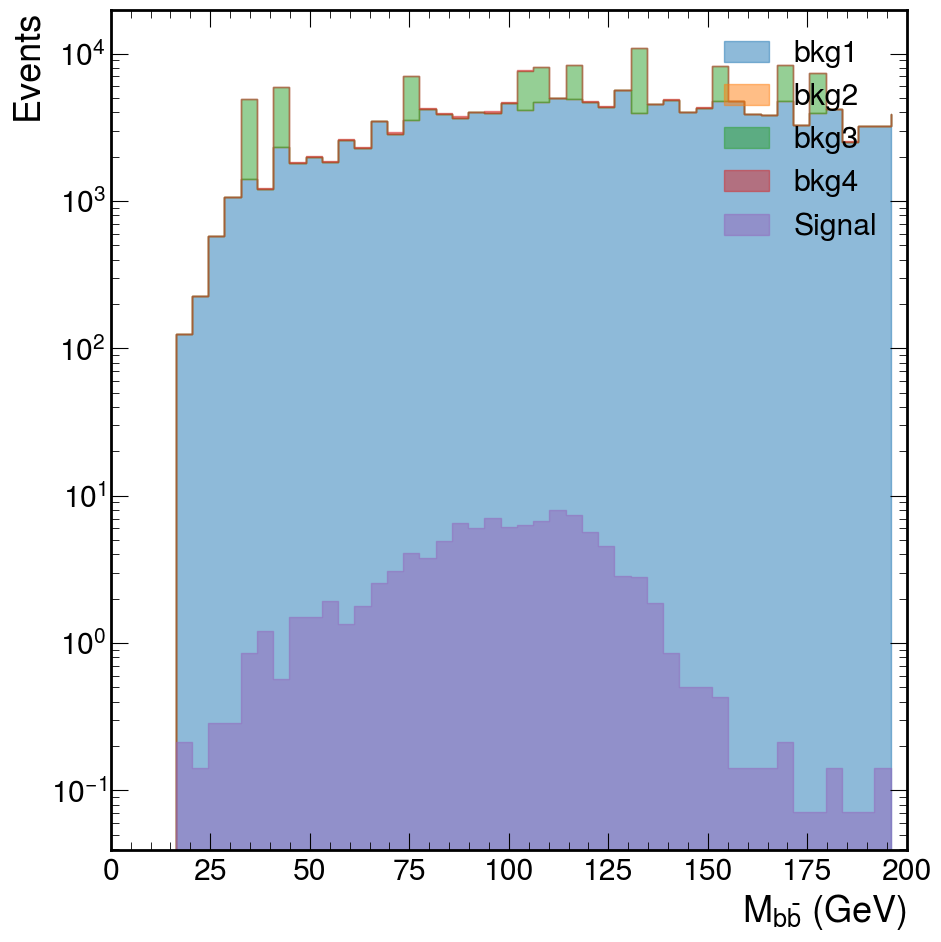

In [9]:
def plot_mass_bb():
    mass_bins = np.linspace(0, 200, 50)
    signal_mass = np.array(signal['BB_mass'])
    bkg1_mass = np.array(bkg1['BB_mass'])
    bkg2_mass = np.array(bkg2['BB_mass'])
    bkg3_mass = np.array(bkg3['BB_mass'])
    bkg4_mass = np.array(bkg4['BB_mass'])
    
    signal_mass_mean, signal_mass_std, signal_mass_bin_c = ht.calculate_hist_stats(
        signal_mass, int(lumi[0])+1, mass_bins)
    bkg1_mass_mean, bkg1_mass_std, bkg1_mass_bin_c = ht.calculate_hist_stats(
        bkg1_mass, int(lumi[1])+1, mass_bins)
    bkg2_mass_mean, bkg2_mass_std, bkg2_mass_bin_c = ht.calculate_hist_stats(
        bkg2_mass, int(lumi[2])+1, mass_bins)
    bkg3_mass_mean, bkg3_mass_std, bkg3_mass_bin_c = ht.calculate_hist_stats(
        bkg3_mass, int(lumi[3])+1, mass_bins)
    bkg4_mass_mean, bkg4_mass_std, bkg4_mass_bin_c = ht.calculate_hist_stats(
        bkg4_mass, int(lumi[4])+1, mass_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    # 使用堆叠函数
    plot_stacked_fill(
        bins=mass_bins,
        datasets=[bkg1_mass_mean, bkg2_mass_std, bkg3_mass_mean, bkg4_mass_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],  # 前4个颜色给背景
        signal_data=signal_mass_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$M_{b\\bar{b}}$ (GeV)")
    plt.ylabel("Events")
    plt.xlim(0, 200)
    plt.yscale('log')
    plt.legend(loc='upper right')

plot_mass_bb()
plt.tight_layout()
plt.savefig("figures/BB_mass.png", dpi=300)

# * # * # * # * # # * # * # * # * # # * # * # * # * # # * # * # * # * # # * # * # * # * # # * # * # * # * # # * # * # * # * # # * # * # * # * # 

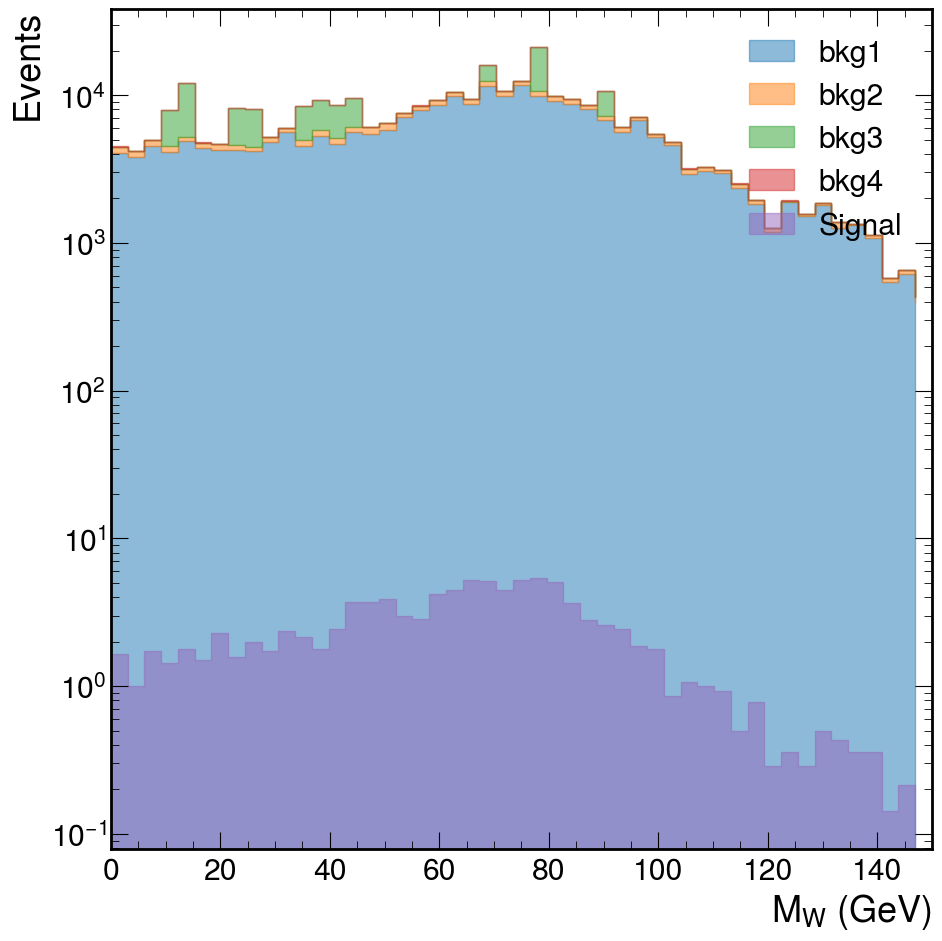

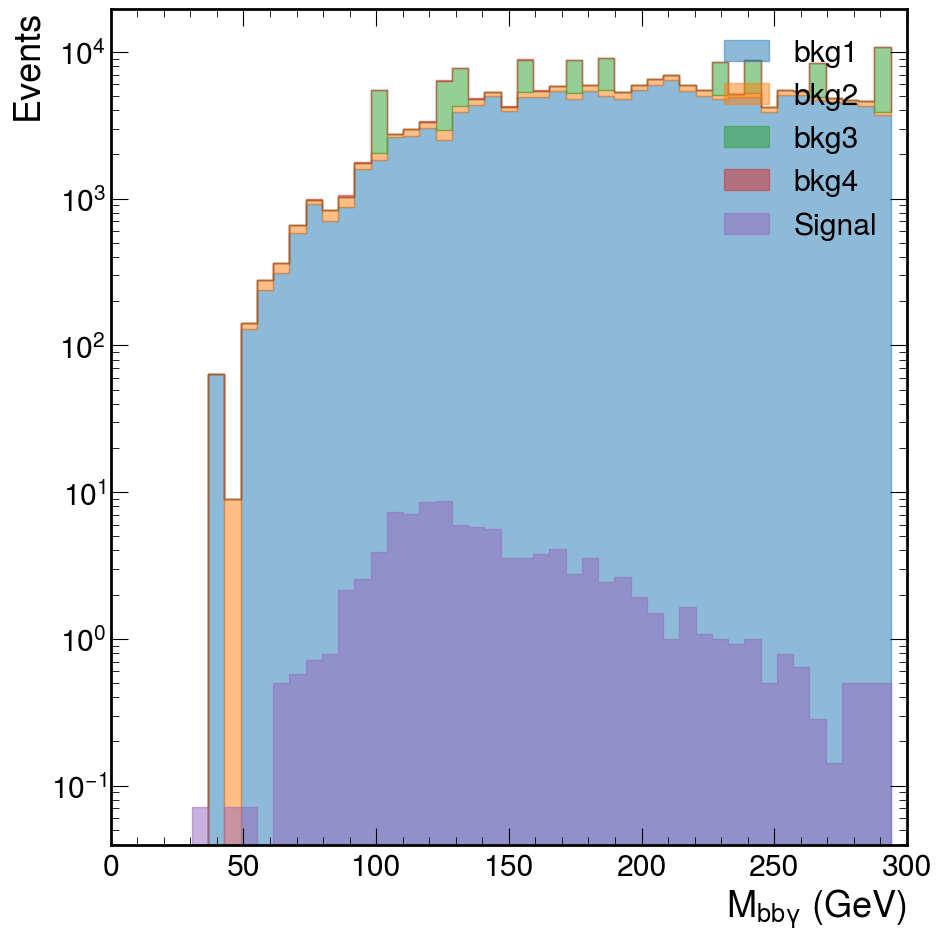

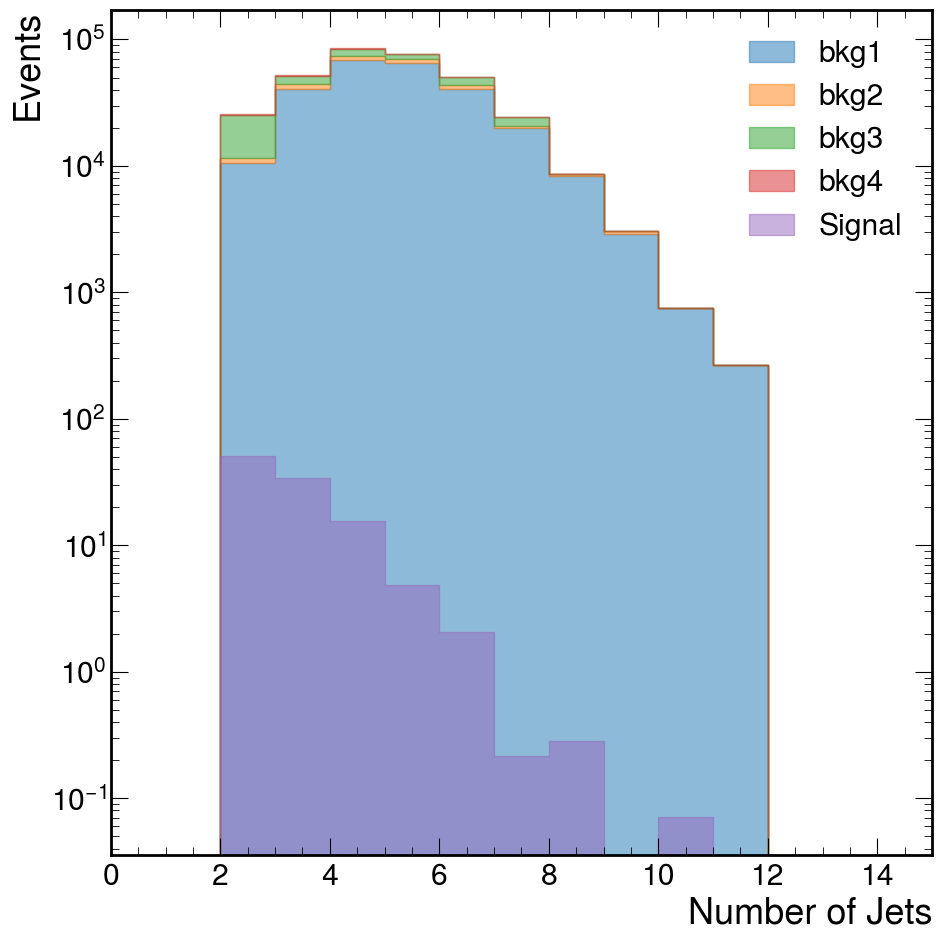

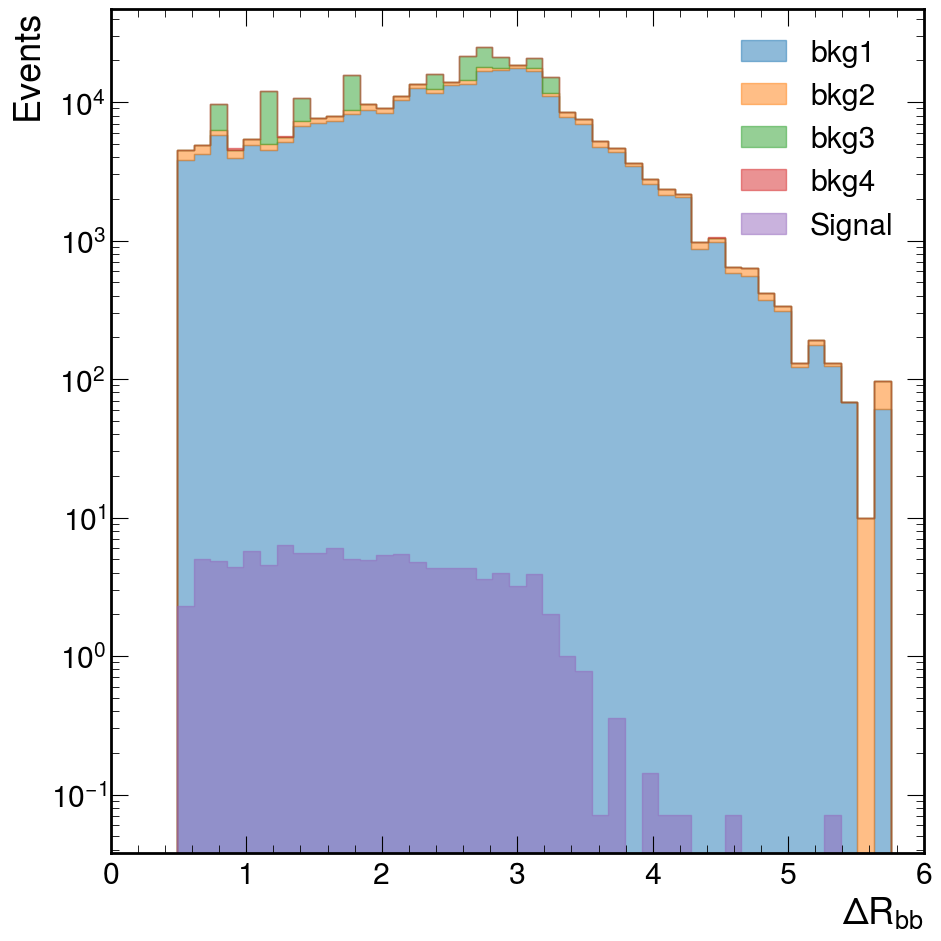

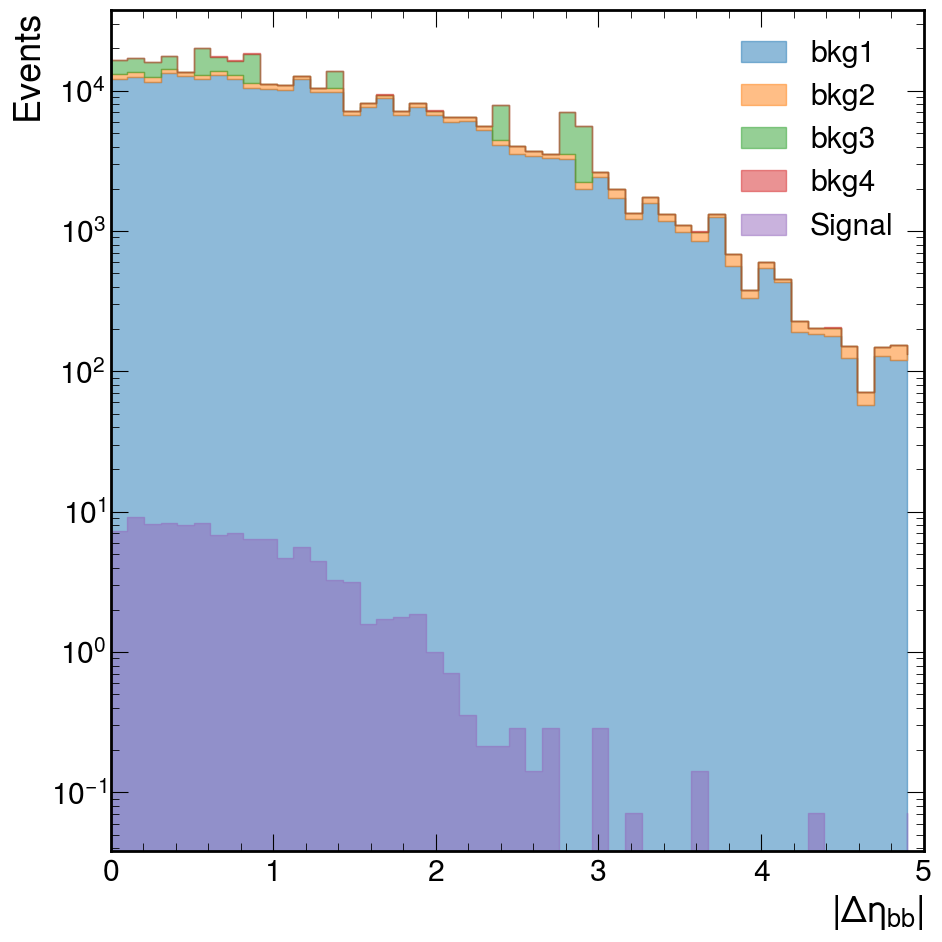

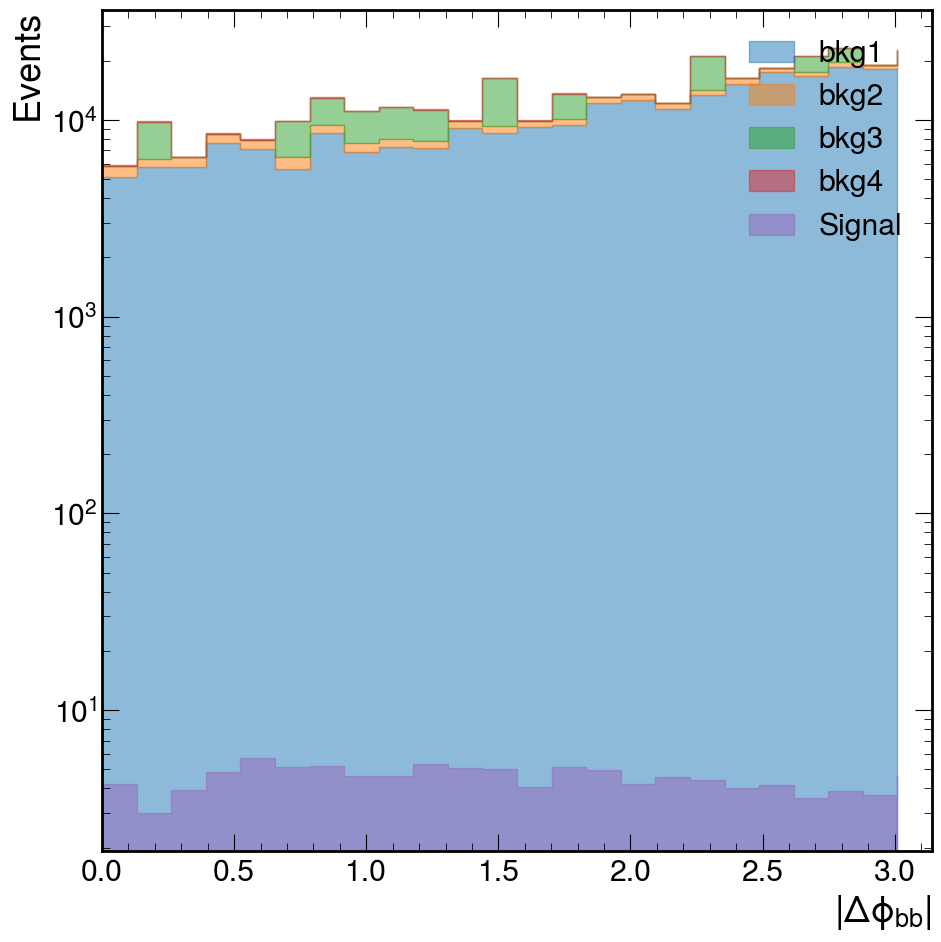

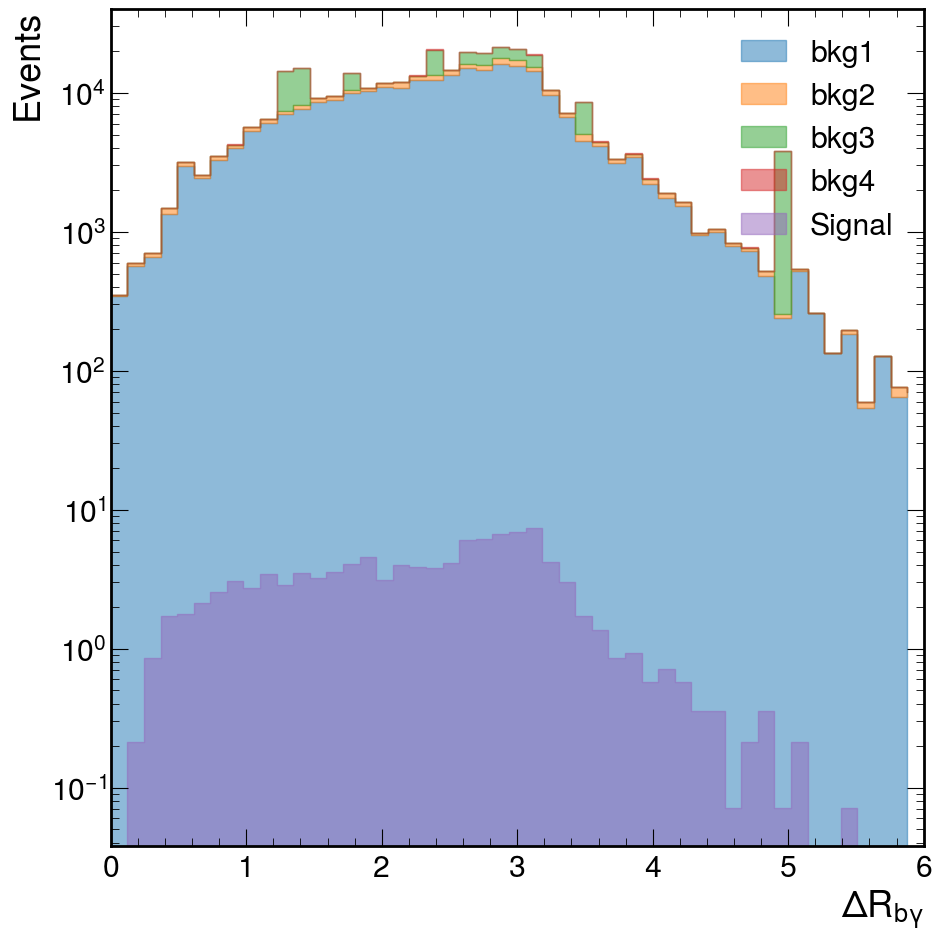

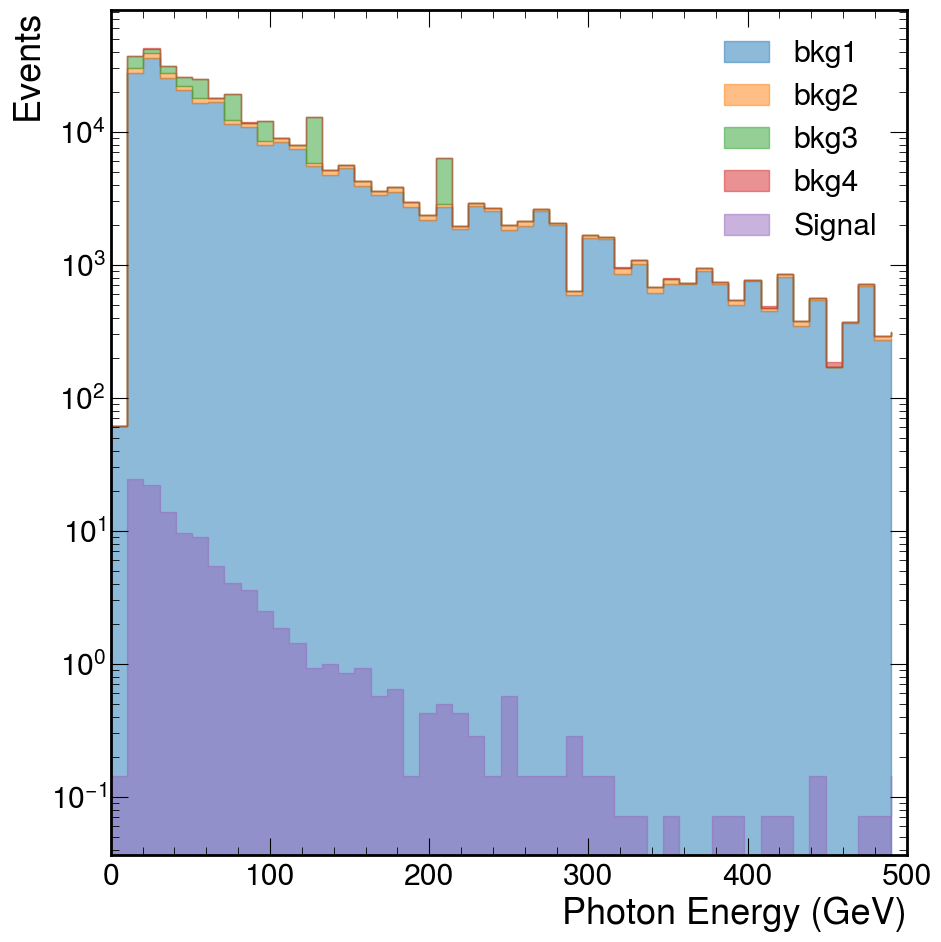

In [39]:
# 仿照plot_mass_bb()创建其他变量的绘图函数

def plot_w_mass():
    """绘制W质量分布"""
    mass_bins = np.linspace(0, 150, 50)  # W玻色子质量范围通常在80GeV左右
    signal_mass = np.array(signal['W_mass'])
    bkg1_mass = np.array(bkg1['W_mass'])
    bkg2_mass = np.array(bkg2['W_mass'])
    bkg3_mass = np.array(bkg3['W_mass'])
    bkg4_mass = np.array(bkg4['W_mass'])
    
    signal_mass_mean, signal_mass_std, signal_mass_bin_c = ht.calculate_hist_stats(
        signal_mass, int(lumi[0])+1, mass_bins)
    bkg1_mass_mean, bkg1_mass_std, bkg1_mass_bin_c = ht.calculate_hist_stats(
        bkg1_mass, int(lumi[1])+1, mass_bins)
    bkg2_mass_mean, bkg2_mass_std, bkg2_mass_bin_c = ht.calculate_hist_stats(
        bkg2_mass, int(lumi[2])+1, mass_bins)
    bkg3_mass_mean, bkg3_mass_std, bkg3_mass_bin_c = ht.calculate_hist_stats(
        bkg3_mass, int(lumi[3])+1, mass_bins)
    bkg4_mass_mean, bkg4_mass_std, bkg4_mass_bin_c = ht.calculate_hist_stats(
        bkg4_mass, int(lumi[4])+1, mass_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=mass_bins,
        datasets=[bkg1_mass_mean, bkg2_mass_mean, bkg3_mass_mean, bkg4_mass_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_mass_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$M_W$ (GeV)")
    plt.ylabel("Events")
    plt.xlim(0, 150)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_bba_mass():
    """绘制BBA质量分布"""
    mass_bins = np.linspace(0, 300, 50)  # BBA质量范围可能更大
    signal_mass = np.array(signal['BBA_mass'])
    bkg1_mass = np.array(bkg1['BBA_mass'])
    bkg2_mass = np.array(bkg2['BBA_mass'])
    bkg3_mass = np.array(bkg3['BBA_mass'])
    bkg4_mass = np.array(bkg4['BBA_mass'])
    
    signal_mass_mean, signal_mass_std, signal_mass_bin_c = ht.calculate_hist_stats(
        signal_mass, int(lumi[0])+1, mass_bins)
    bkg1_mass_mean, bkg1_mass_std, bkg1_mass_bin_c = ht.calculate_hist_stats(
        bkg1_mass, int(lumi[1])+1, mass_bins)
    bkg2_mass_mean, bkg2_mass_std, bkg2_mass_bin_c = ht.calculate_hist_stats(
        bkg2_mass, int(lumi[2])+1, mass_bins)
    bkg3_mass_mean, bkg3_mass_std, bkg3_mass_bin_c = ht.calculate_hist_stats(
        bkg3_mass, int(lumi[3])+1, mass_bins)
    bkg4_mass_mean, bkg4_mass_std, bkg4_mass_bin_c = ht.calculate_hist_stats(
        bkg4_mass, int(lumi[4])+1, mass_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=mass_bins,
        datasets=[bkg1_mass_mean, bkg2_mass_mean, bkg3_mass_mean, bkg4_mass_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_mass_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$M_{bb\\gamma}$ (GeV)")
    plt.ylabel("Events")
    plt.xlim(0, 300)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_njet():
    """绘制喷注数分布"""
    njet_bins = np.linspace(0, 15, 16)  # 喷注数通常是整数，0-15个
    signal_njet = np.array(signal['Njet'])
    bkg1_njet = np.array(bkg1['Njet'])
    bkg2_njet = np.array(bkg2['Njet'])
    bkg3_njet = np.array(bkg3['Njet'])
    bkg4_njet = np.array(bkg4['Njet'])
    
    signal_njet_mean, signal_njet_std, signal_njet_bin_c = ht.calculate_hist_stats(
        signal_njet, int(lumi[0])+1, njet_bins)
    bkg1_njet_mean, bkg1_njet_std, bkg1_njet_bin_c = ht.calculate_hist_stats(
        bkg1_njet, int(lumi[1])+1, njet_bins)
    bkg2_njet_mean, bkg2_njet_std, bkg2_njet_bin_c = ht.calculate_hist_stats(
        bkg2_njet, int(lumi[2])+1, njet_bins)
    bkg3_njet_mean, bkg3_njet_std, bkg3_njet_bin_c = ht.calculate_hist_stats(
        bkg3_njet, int(lumi[3])+1, njet_bins)
    bkg4_njet_mean, bkg4_njet_std, bkg4_njet_bin_c = ht.calculate_hist_stats(
        bkg4_njet, int(lumi[4])+1, njet_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=njet_bins,
        datasets=[bkg1_njet_mean, bkg2_njet_mean, bkg3_njet_mean, bkg4_njet_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_njet_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("Number of Jets")
    plt.ylabel("Events")
    plt.xlim(0, 15)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_db_delta_r():
    """绘制dB_delta_r分布"""
    dr_bins = np.linspace(0, 6, 50)  # ΔR通常在0-6范围内
    signal_dr = np.array(signal['dB_delta_r'])
    bkg1_dr = np.array(bkg1['dB_delta_r'])
    bkg2_dr = np.array(bkg2['dB_delta_r'])
    bkg3_dr = np.array(bkg3['dB_delta_r'])
    bkg4_dr = np.array(bkg4['dB_delta_r'])
    
    signal_dr_mean, signal_dr_std, signal_dr_bin_c = ht.calculate_hist_stats(
        signal_dr, int(lumi[0])+1, dr_bins)
    bkg1_dr_mean, bkg1_dr_std, bkg1_dr_bin_c = ht.calculate_hist_stats(
        bkg1_dr, int(lumi[1])+1, dr_bins)
    bkg2_dr_mean, bkg2_dr_std, bkg2_dr_bin_c = ht.calculate_hist_stats(
        bkg2_dr, int(lumi[2])+1, dr_bins)
    bkg3_dr_mean, bkg3_dr_std, bkg3_dr_bin_c = ht.calculate_hist_stats(
        bkg3_dr, int(lumi[3])+1, dr_bins)
    bkg4_dr_mean, bkg4_dr_std, bkg4_dr_bin_c = ht.calculate_hist_stats(
        bkg4_dr, int(lumi[4])+1, dr_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=dr_bins,
        datasets=[bkg1_dr_mean, bkg2_dr_mean, bkg3_dr_mean, bkg4_dr_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_dr_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$\\Delta R_{bb}$")
    plt.ylabel("Events")
    plt.xlim(0, 6)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_db_delta_eta():
    """绘制dB_delta_eta分布"""
    deta_bins = np.linspace(0, 5, 50)  # Δη通常在-5到5范围内
    signal_deta = np.array(signal['dB_delta_eta'])
    bkg1_deta = np.array(bkg1['dB_delta_eta'])
    bkg2_deta = np.array(bkg2['dB_delta_eta'])
    bkg3_deta = np.array(bkg3['dB_delta_eta'])
    bkg4_deta = np.array(bkg4['dB_delta_eta'])
    
    signal_deta_mean, signal_deta_std, signal_deta_bin_c = ht.calculate_hist_stats(
        signal_deta, int(lumi[0])+1, deta_bins)
    bkg1_deta_mean, bkg1_deta_std, bkg1_deta_bin_c = ht.calculate_hist_stats(
        bkg1_deta, int(lumi[1])+1, deta_bins)
    bkg2_deta_mean, bkg2_deta_std, bkg2_deta_bin_c = ht.calculate_hist_stats(
        bkg2_deta, int(lumi[2])+1, deta_bins)
    bkg3_deta_mean, bkg3_deta_std, bkg3_deta_bin_c = ht.calculate_hist_stats(
        bkg3_deta, int(lumi[3])+1, deta_bins)
    bkg4_deta_mean, bkg4_deta_std, bkg4_deta_bin_c = ht.calculate_hist_stats(
        bkg4_deta, int(lumi[4])+1, deta_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=deta_bins,
        datasets=[bkg1_deta_mean, bkg2_deta_mean, bkg3_deta_mean, bkg4_deta_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_deta_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$|\\Delta \\eta_{bb}|$")
    plt.ylabel("Events")
    plt.xlim(0, 5)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_db_delta_phi():
    """绘制dB_delta_phi分布"""
    dphi_bins = np.linspace(0, np.pi, 25)  # Δφ通常在-π到π范围内
    signal_dphi = np.array(signal['dB_delta_phi'])
    bkg1_dphi = np.array(bkg1['dB_delta_phi'])
    bkg2_dphi = np.array(bkg2['dB_delta_phi'])
    bkg3_dphi = np.array(bkg3['dB_delta_phi'])
    bkg4_dphi = np.array(bkg4['dB_delta_phi'])
    
    signal_dphi_mean, signal_dphi_std, signal_dphi_bin_c = ht.calculate_hist_stats(
        signal_dphi, int(lumi[0])+1, dphi_bins)
    bkg1_dphi_mean, bkg1_dphi_std, bkg1_dphi_bin_c = ht.calculate_hist_stats(
        bkg1_dphi, int(lumi[1])+1, dphi_bins)
    bkg2_dphi_mean, bkg2_dphi_std, bkg2_dphi_bin_c = ht.calculate_hist_stats(
        bkg2_dphi, int(lumi[2])+1, dphi_bins)
    bkg3_dphi_mean, bkg3_dphi_std, bkg3_dphi_bin_c = ht.calculate_hist_stats(
        bkg3_dphi, int(lumi[3])+1, dphi_bins)
    bkg4_dphi_mean, bkg4_dphi_std, bkg4_dphi_bin_c = ht.calculate_hist_stats(
        bkg4_dphi, int(lumi[4])+1, dphi_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=dphi_bins,
        datasets=[bkg1_dphi_mean, bkg2_dphi_mean, bkg3_dphi_mean, bkg4_dphi_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_dphi_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$|\\Delta \\phi_{bb}|$")
    plt.ylabel("Events")
    plt.xlim(0, np.pi)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_bp_delta_r():
    """绘制bP_delta_r分布"""
    dr_bins = np.linspace(0, 6, 50)  # ΔR通常在0-6范围内
    signal_dr = np.array(signal['bP_delta_r'])
    bkg1_dr = np.array(bkg1['bP_delta_r'])
    bkg2_dr = np.array(bkg2['bP_delta_r'])
    bkg3_dr = np.array(bkg3['bP_delta_r'])
    bkg4_dr = np.array(bkg4['bP_delta_r'])
    
    signal_dr_mean, signal_dr_std, signal_dr_bin_c = ht.calculate_hist_stats(
        signal_dr, int(lumi[0])+1, dr_bins)
    bkg1_dr_mean, bkg1_dr_std, bkg1_dr_bin_c = ht.calculate_hist_stats(
        bkg1_dr, int(lumi[1])+1, dr_bins)
    bkg2_dr_mean, bkg2_dr_std, bkg2_dr_bin_c = ht.calculate_hist_stats(
        bkg2_dr, int(lumi[2])+1, dr_bins)
    bkg3_dr_mean, bkg3_dr_std, bkg3_dr_bin_c = ht.calculate_hist_stats(
        bkg3_dr, int(lumi[3])+1, dr_bins)
    bkg4_dr_mean, bkg4_dr_std, bkg4_dr_bin_c = ht.calculate_hist_stats(
        bkg4_dr, int(lumi[4])+1, dr_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=dr_bins,
        datasets=[bkg1_dr_mean, bkg2_dr_mean, bkg3_dr_mean, bkg4_dr_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_dr_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("$\\Delta R_{b\\gamma}$")
    plt.ylabel("Events")
    plt.xlim(0, 6)
    plt.yscale('log')
    plt.legend(loc='upper right')

def plot_photon_energy():
    """绘制光子能量分布"""
    energy_bins = np.linspace(0, 500, 50)  # 光子能量范围，根据实际情况调整
    signal_energy = np.array(signal['photon_energy'])
    bkg1_energy = np.array(bkg1['photon_energy'])
    bkg2_energy = np.array(bkg2['photon_energy'])
    bkg3_energy = np.array(bkg3['photon_energy'])
    bkg4_energy = np.array(bkg4['photon_energy'])
    
    signal_energy_mean, signal_energy_std, signal_energy_bin_c = ht.calculate_hist_stats(
        signal_energy, int(lumi[0])+1, energy_bins)
    bkg1_energy_mean, bkg1_energy_std, bkg1_energy_bin_c = ht.calculate_hist_stats(
        bkg1_energy, int(lumi[1])+1, energy_bins)
    bkg2_energy_mean, bkg2_energy_std, bkg2_energy_bin_c = ht.calculate_hist_stats(
        bkg2_energy, int(lumi[2])+1, energy_bins)
    bkg3_energy_mean, bkg3_energy_std, bkg3_energy_bin_c = ht.calculate_hist_stats(
        bkg3_energy, int(lumi[3])+1, energy_bins)
    bkg4_energy_mean, bkg4_energy_std, bkg4_energy_bin_c = ht.calculate_hist_stats(
        bkg4_energy, int(lumi[4])+1, energy_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    plt.style.use(hep.style.CMS)
    
    plot_stacked_fill(
        bins=energy_bins,
        datasets=[bkg1_energy_mean, bkg2_energy_mean, bkg3_energy_mean, bkg4_energy_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_energy_mean,
        signal_label='Signal'
    )
    
    plt.xlabel("Photon Energy (GeV)")
    plt.ylabel("Events")
    plt.xlim(0, 500)
    plt.yscale('log')
    plt.legend(loc='upper right')
plot_w_mass()
plt.tight_layout()
plt.savefig("figures/W_mass.png", dpi=300)
plot_bba_mass()
plt.tight_layout()
plt.savefig("figures/BBA_mass.png", dpi=300)
plot_njet()
plt.tight_layout()
plt.savefig("figures/Njet.png", dpi=300)
plot_db_delta_r() 
plt.tight_layout()
plt.savefig("figures/dB_delta_r.png", dpi=300)
plot_db_delta_eta()
plt.tight_layout()
plt.savefig("figures/dB_delta_eta.png", dpi=300)
plot_db_delta_phi()
plt.tight_layout()
plt.savefig("figures/dB_delta_phi.png", dpi=300)
plot_bp_delta_r()
plt.tight_layout()
plt.savefig("figures/bP_delta_r.png", dpi=300)
plot_photon_energy()
plt.tight_layout()
plt.savefig("figures/photon_energy.png", dpi=300)

Signal: 1,464 valid events (原始: 1,568)
Background 1: 2,456 valid events (原始: 4,144)
Background 2: 1,350 valid events (原始: 2,042)
Background 3: 11 valid events (原始: 14)
Background 4: 61 valid events (原始: 76)


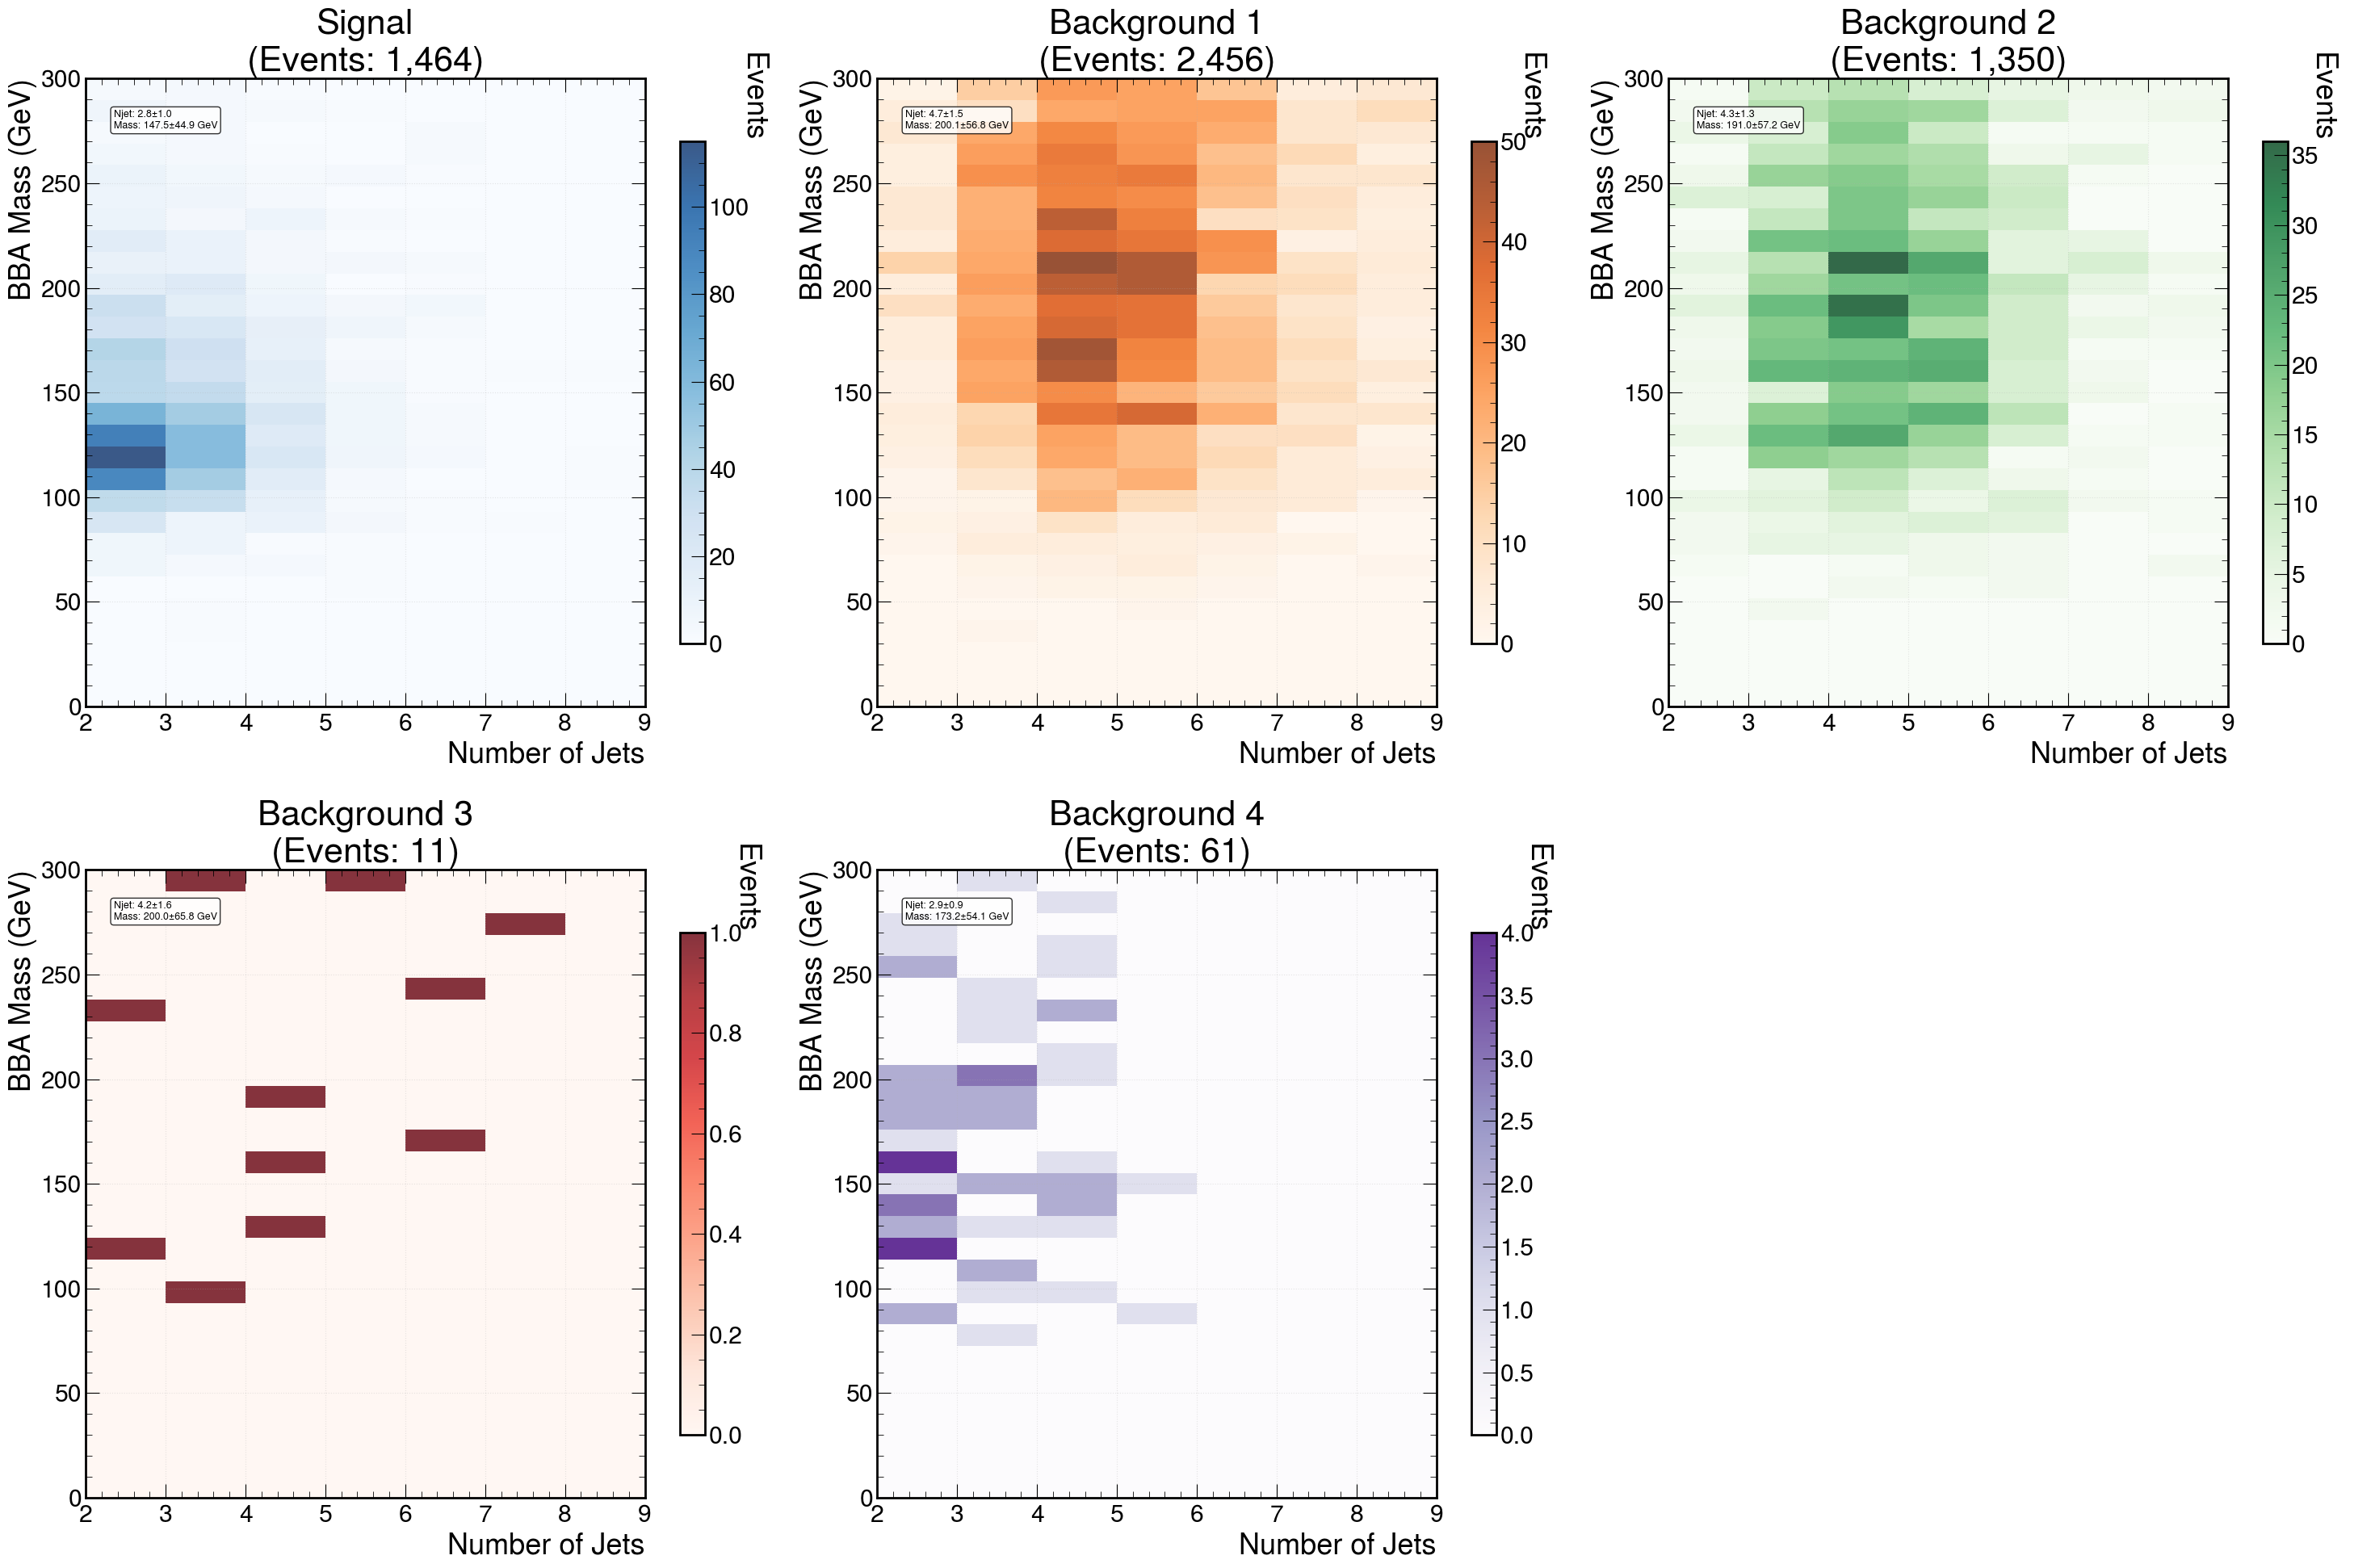

In [25]:
# import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_2d_heatmap_from_arrays(signal_mass, signal_njet, 
                                bkg1_mass, bkg1_njet,
                                bkg2_mass, bkg2_njet, 
                                bkg3_mass, bkg3_njet,
                                bkg4_mass, bkg4_njet):
    """
    从numpy数组绘制Njet vs BBA_mass的2D热图分布
    
    参数:
    - signal_mass, signal_njet: Signal过程的BBA质量和喷注数数组
    - bkg1_mass, bkg1_njet: Background 1的数组
    - bkg2_mass, bkg2_njet: Background 2的数组  
    - bkg3_mass, bkg3_njet: Background 3的数组
    - bkg4_mass, bkg4_njet: Background 4的数组
    """
    
    # 设置bins
    njet_bins = np.arange(2, 10, 1)  # 喷注数：0-15
    bba_mass_bins = np.linspace(0, 300, 30)  # BBA质量：0-300 GeV
    
    # 准备数据字典
    datasets = {
        'Signal': {'mass': signal_mass, 'njet': signal_njet},
        'Background 1': {'mass': bkg1_mass, 'njet': bkg1_njet},
        'Background 2': {'mass': bkg2_mass, 'njet': bkg2_njet},
        'Background 3': {'mass': bkg3_mass, 'njet': bkg3_njet},
        'Background 4': {'mass': bkg4_mass, 'njet': bkg4_njet}
    }
    
    # 创建2x3的子图布局
    fig, axes = plt.subplots(2, 3, figsize=(30, 20))
    # fig.suptitle('2D Heatmap Distribution: Number of Jets vs BBA Mass', fontsize=16, fontweight='bold')
    
    # 颜色映射
    cmaps = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']
    
    # 存储所有直方图数据用于最后的combined图
    all_hists = []
    all_labels = []
    
    # 绘制每个过程的2D热图
    for i, (name, data) in enumerate(datasets.items()):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        # 提取数据
        mass_data = np.array(data['mass'])
        njet_data = np.array(data['njet'])
        
        # 过滤掉NaN和超出范围的数据
        valid_mask = (~np.isnan(mass_data)) & (~np.isnan(njet_data)) & \
                    (njet_data >= 0) & (njet_data < 15) & \
                    (mass_data >= 0) & (mass_data <= 300)
        
        mass_filtered = mass_data[valid_mask]
        njet_filtered = njet_data[valid_mask]
        
        print(f"{name}: {len(mass_filtered):,} valid events (原始: {len(mass_data):,})")
        
        # 创建2D直方图 (注意：x轴是njet，y轴是mass)
        hist, xedges, yedges = np.histogram2d(njet_filtered, mass_filtered, 
                                            bins=[njet_bins, bba_mass_bins])
        
        # 存储数据用于combined图
        all_hists.append(hist)
        all_labels.append(name)
        
        # 绘制热图
        im = ax.imshow(hist.T, origin='lower', aspect='auto', 
                      extent=[njet_bins[0], njet_bins[-1], bba_mass_bins[0], bba_mass_bins[-1]],
                      cmap=cmaps[i], alpha=0.8)
        
        # 添加颜色条
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label('Events', rotation=270, labelpad=15)
        
        # 设置标签和标题
        ax.set_xlabel('Number of Jets')
        ax.set_ylabel('BBA Mass (GeV)')
        ax.set_title(f'{name}\n(Events: {len(njet_filtered):,})')
        ax.grid(True, alpha=0.3)
        
        # 添加统计信息
        if len(njet_filtered) > 0:
            mean_njet = np.mean(njet_filtered)
            mean_mass = np.mean(mass_filtered)
            std_njet = np.std(njet_filtered)
            std_mass = np.std(mass_filtered)
            
            ax.text(0.05, 0.95, 
                   f'Njet: {mean_njet:.1f}±{std_njet:.1f}\nMass: {mean_mass:.1f}±{std_mass:.1f} GeV', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=9)
    
    # 最后一个子图：Combined contours
    ax_combined = axes[1, 2]
    
    # 绘制所有过程的轮廓线
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    
    for i, (hist, label, color) in enumerate(zip(all_hists, all_labels, colors)):
        # 创建网格
        X, Y = np.meshgrid((njet_bins[:-1] + njet_bins[1:])/2, 
                          (bba_mass_bins[:-1] + bba_mass_bins[1:])/2)
        
        # 绘制轮廓线
        if np.max(hist) > 0:  # 确保有数据
            max_val = np.max(hist)
            levels = np.linspace(max_val*0.1, max_val*0.9, 5)
            cs = ax_combined.contour(X, Y, hist.T, levels=levels, colors=[color], 
                                   linewidths=2, alpha=0.8)
    
    ax_combined.set_xlabel('Number of Jets')
    ax_combined.set_ylabel('BBA Mass (GeV)')
    ax_combined.set_title('Combined Contours\n(All Processes)')
    ax_combined.grid(True, alpha=0.3)
    
    # 添加图例
    legend_elements = [plt.Line2D([0], [0], color=color, lw=2, label=label) 
                      for color, label in zip(colors, all_labels)]
    ax_combined.legend(handles=legend_elements, loc='upper right', fontsize=10)
    # 设置最后一个子图为空
    ax_combined.clear()
    ax_combined.set_axis_off()
    plt.tight_layout()
    plt.savefig("figures/Njet_vs_BBA_mass.png", dpi=300)
    # return fig


def plot_2d_heatmap():
    signal_mass = np.array(signal['BBA_mass'])
    signal_njet = np.array(signal['Njet'])
    
    bkg1_mass = np.array(bkg1['BBA_mass'])
    bkg1_njet = np.array(bkg1['Njet'])
    
    bkg2_mass = np.array(bkg2['BBA_mass'])
    bkg2_njet = np.array(bkg2['Njet'])
    
    bkg3_mass = np.array(bkg3['BBA_mass'])
    bkg3_njet = np.array(bkg3['Njet'])
    
    bkg4_mass = np.array(bkg4['BBA_mass'])
    bkg4_njet = np.array(bkg4['Njet'])
    plot_2d_heatmap_from_arrays(signal_mass, signal_njet,
                                    bkg1_mass, bkg1_njet,
                                    bkg2_mass, bkg2_njet,
                                    bkg3_mass, bkg3_njet,
                                    bkg4_mass, bkg4_njet)
    plt.tight_layout()
    plt.savefig("figures/Njet_vs_BBA_mass.png", dpi=300)
plot_2d_heatmap()


绘制BB质量分布 (Njet切割: 2≤Njet≤3)...
# * # * # * # * # Signal area in [50,175] GeV: 519.0
Background areas in [50,175] GeV: bkg1=83516.7, bkg2=11841.7, bkg3=57841.7, bkg4=2300.0, total=155500.0
significant: 1.316260978527765


/tmp/youpeng/ipykernel_4112470/3218523371.py:140: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from font(s) TeX Gyre Heros.
  fig2.savefig("figures/BBA_mass_with_njet_cut.png", dpi=300)
/eos/home-y/youpeng/miniforge3/envs/oldcoffeaenv/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from font(s) TeX Gyre Heros.
  func(*args, **kwargs)
/eos/home-y/youpeng/miniforge3/envs/oldcoffeaenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from font(s) TeX Gyre Heros.
  fig.canvas.print_figure(bytes_io, **kw)


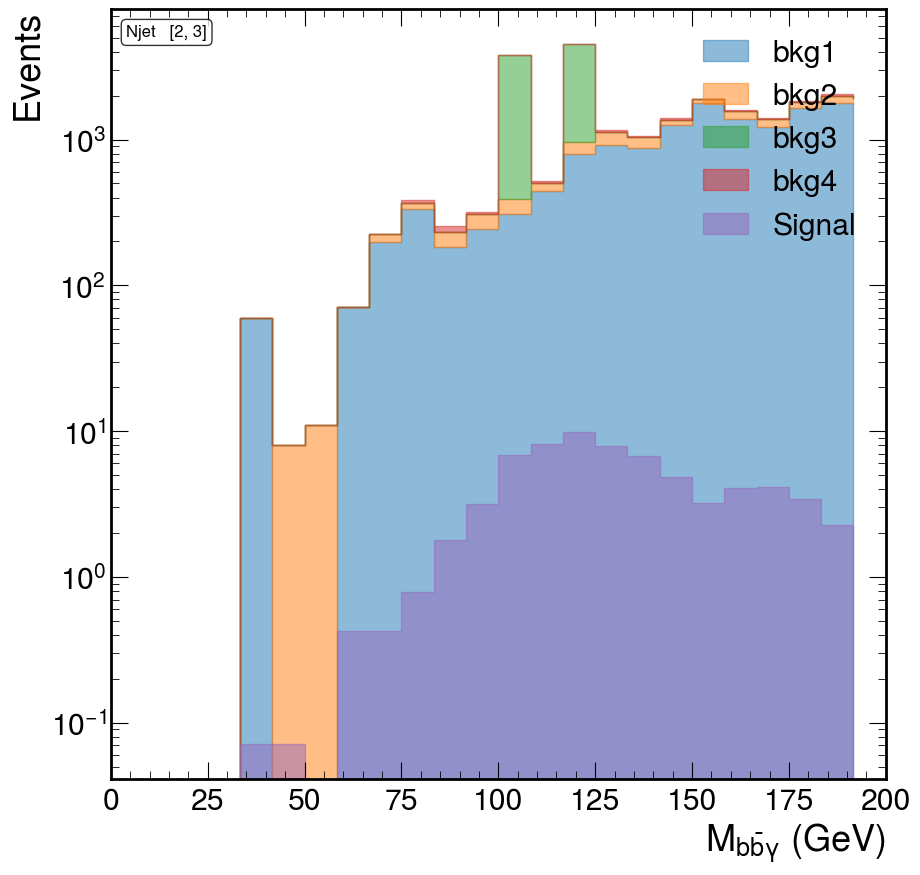

In [ ]:
def plot_mass_bb_with_njet_cut(signal_mass, signal_njet,
                                              bkg1_mass, bkg1_njet,
                                              bkg2_mass, bkg2_njet,
                                              bkg3_mass, bkg3_njet,
                                              bkg4_mass, bkg4_njet,
                                              lumi_factors,
                                              njet_min=2, njet_max=3):

    print(f"\n绘制BB质量分布 (Njet切割: {njet_min}≤Njet≤{njet_max})...")
    
    signal_mask = (signal_njet >= njet_min) & (signal_njet <= njet_max)
    bkg1_mask = (bkg1_njet >= njet_min) & (bkg1_njet <= njet_max)
    bkg2_mask = (bkg2_njet >= njet_min) & (bkg2_njet <= njet_max)
    bkg3_mask = (bkg3_njet >= njet_min) & (bkg3_njet <= njet_max)
    bkg4_mask = (bkg4_njet >= njet_min) & (bkg4_njet <= njet_max)
    
    signal_mass_filtered = signal_mass[signal_mask]
    bkg1_mass_filtered = bkg1_mass[bkg1_mask]
    bkg2_mass_filtered = bkg2_mass[bkg2_mask]
    bkg3_mass_filtered = bkg3_mass[bkg3_mask]
    bkg4_mass_filtered = bkg4_mass[bkg4_mask]
    
    mass_bins = np.linspace(0, 200, 25)
    
    signal_mass_array = np.array(signal_mass_filtered)
    bkg1_mass_array = np.array(bkg1_mass_filtered)
    bkg2_mass_array = np.array(bkg2_mass_filtered)
    bkg3_mass_array = np.array(bkg3_mass_filtered)
    bkg4_mass_array = np.array(bkg4_mass_filtered)
    # calculate new factors
    
    lumi_factors = [lumi[0]*(len(signal_mass_filtered)/len(signal_njet)),
                   lumi[1]*(len(bkg1_mass_filtered))/len(bkg1_njet),
                   lumi[2]*(len(bkg2_mass_filtered))/len(bkg2_njet),
                   lumi[3]*(len(bkg3_mass_filtered))/len(bkg3_njet),
                   lumi[4]*(len(bkg4_mass_filtered))/len(bkg4_njet)]
    # print(
    #     f"signal: {}, {len(signal_njet)}\n",
    #     f"bkg1: {}, {len(bkg1_njet)}\n",
    #     f"bkg2: {}, {len(bkg2_njet)}\n",
    #     f"bkg3: {}, {len(bkg3_njet)}\n",
    #     f"bkg4: {}, {len(bkg4_njet)}\n"
    # )
    # significant = len(signal_mass_filtered)* lumi_factors[0] / \
    #                 np.sqrt((    len(bkg1_mass_filtered)* lumi_factors[1] +
    #                     len(bkg2_mass_filtered)* lumi_factors[2] +
    #                     len(bkg3_mass_filtered)* lumi_factors[3] +
    #                     len(bkg4_mass_filtered)* lumi_factors[4]))
    # print("significant", significant)
    # print("event", len(signal_mass_filtered)/ lumi_factors[0],\
    #       "bkgs" , len(bkg1_mass_filtered)/ lumi_factors[1] , ",",\
    #         len(bkg2_mass_filtered)/ lumi_factors[2] , ",",\
    #         len(bkg3_mass_filtered)/ lumi_factors[3] , ",",\
    #         len(bkg4_mass_filtered)/ lumi_factors[4])
    # print("significant", pow(signal_mask.sum()/(bkg1_mask.sum() + bkg2_mask.sum() + bkg3_mask.sum() + bkg4_mask.sum()), 0.5))
    
    signal_mass_mean, signal_mass_std, signal_mass_bin_c = ht.calculate_hist_stats(
        signal_mass_array, int(lumi_factors[0])+1, mass_bins)
    bkg1_mass_mean, bkg1_mass_std, bkg1_mass_bin_c = ht.calculate_hist_stats(
        bkg1_mass_array, int(lumi_factors[1])+1, mass_bins)
    bkg2_mass_mean, bkg2_mass_std, bkg2_mass_bin_c = ht.calculate_hist_stats(
        bkg2_mass_array, int(lumi_factors[2])+1, mass_bins)
    bkg3_mass_mean, bkg3_mass_std, bkg3_mass_bin_c = ht.calculate_hist_stats(
        bkg3_mass_array, int(lumi_factors[3])+1, mass_bins)
    bkg4_mass_mean, bkg4_mass_std, bkg4_mass_bin_c = ht.calculate_hist_stats(
        bkg4_mass_array, int(lumi_factors[4])+1, mass_bins)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    # plt.style.use(hep.style.CMS)  # 如果有hep模块可以取消注释
    
    plot_stacked_fill(
        bins=mass_bins,
        datasets=[bkg1_mass_mean, bkg2_mass_mean, bkg3_mass_mean, bkg4_mass_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_mass_mean,
        signal_label='Signal'
    )
    
    # 计算 signal 在 50–175 GeV 范围内的面积
    bin_width = mass_bins[1] - mass_bins[0]
    signal_mask_bins = (signal_mass_bin_c >= 50) & (signal_mass_bin_c <= 175)
    signal_area = signal_mass_mean[signal_mask_bins].sum() * bin_width
    # 计算各个背景在此区间的面积
    bkg1_mask_bins = (bkg1_mass_bin_c >= 50) & (bkg1_mass_bin_c <= 175)
    bkg2_mask_bins = (bkg2_mass_bin_c >= 50) & (bkg2_mass_bin_c <= 175)
    bkg3_mask_bins = (bkg3_mass_bin_c >= 50) & (bkg3_mass_bin_c <= 175)
    bkg4_mask_bins = (bkg4_mass_bin_c >= 50) & (bkg4_mass_bin_c <= 175)

    bkg1_area = bkg1_mass_mean[bkg1_mask_bins].sum() * bin_width
    bkg2_area = bkg2_mass_mean[bkg2_mask_bins].sum() * bin_width
    bkg3_area = bkg3_mass_mean[bkg3_mask_bins].sum() * bin_width
    bkg4_area = bkg4_mass_mean[bkg4_mask_bins].sum() * bin_width

    total_bkg_area = bkg1_area + bkg2_area + bkg3_area + bkg4_area

    print(f"Signal area in [50,175] GeV: {signal_area:.1f}")
    print(f"Background areas in [50,175] GeV: bkg1={bkg1_area:.1f}, bkg2={bkg2_area:.1f}, "
        f"bkg3={bkg3_area:.1f}, bkg4={bkg4_area:.1f}, total={total_bkg_area:.1f}")
    print("significant:", signal_area / np.sqrt(total_bkg_area))


    plt.xlabel(r"$M_{b\bar{b}\gamma}$ (GeV)")
    plt.ylabel("Events")
    plt.xlim(0, 200)
    plt.yscale('log')
    plt.legend(loc='upper right')
    
    plt.text(0.02, 0.98, f'Njet ∈ [{njet_min}, {njet_max}]', 
             transform=plt.gca().transAxes, fontsize=12, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    return plt.gcf()

def plot_mbba_with_njet_cutdo():
    """绘制BBA质量分布，限制喷注数范围为2到5"""
    
    signal_mass = np.array(signal['BBA_mass'])
    signal_njet = np.array(signal['Njet'])
    
    bkg1_mass = np.array(bkg1['BBA_mass'])
    bkg1_njet = np.array(bkg1['Njet'])
    
    bkg2_mass = np.array(bkg2['BBA_mass'])
    bkg2_njet = np.array(bkg2['Njet'])
    
    bkg3_mass = np.array(bkg3['BBA_mass'])
    bkg3_njet = np.array(bkg3['Njet'])
    
    bkg4_mass = np.array(bkg4['BBA_mass'])
    bkg4_njet = np.array(bkg4['Njet'])
    fig2 = plot_mass_bb_with_njet_cut(signal_mass, signal_njet,
                                bkg1_mass, bkg1_njet,
                                bkg2_mass, bkg2_njet,
                                bkg3_mass, bkg3_njet,
                                bkg4_mass, bkg4_njet,
                                lumi,
                                njet_min=2, njet_max=3)
    fig2.savefig("figures/BBA_mass_with_njet_cut.png", dpi=300)

plot_mbba_with_njet_cutdo()




绘制BB质量分布 (Njet切割: 4≤Njet≤6)...
signal: 328, 1568
 bkg1: 2803, 4144
 bkg2: 1390, 2042
 bkg3: 7, 14
 bkg4: 21, 76

# * # * # * # * # Signal area in [50,175] GeV: 120.2
Background areas in [50,175] GeV: bkg1=306675.0, bkg2=29233.3, bkg3=58483.3, bkg4=683.3, total=395075.0
significant: 0.19129442500301497


/tmp/youpeng/ipykernel_4112470/3068360816.py:128: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from font(s) TeX Gyre Heros.
  fig2.savefig("figures/BBA_mass_with_njet_cut_4_6.png", dpi=300)


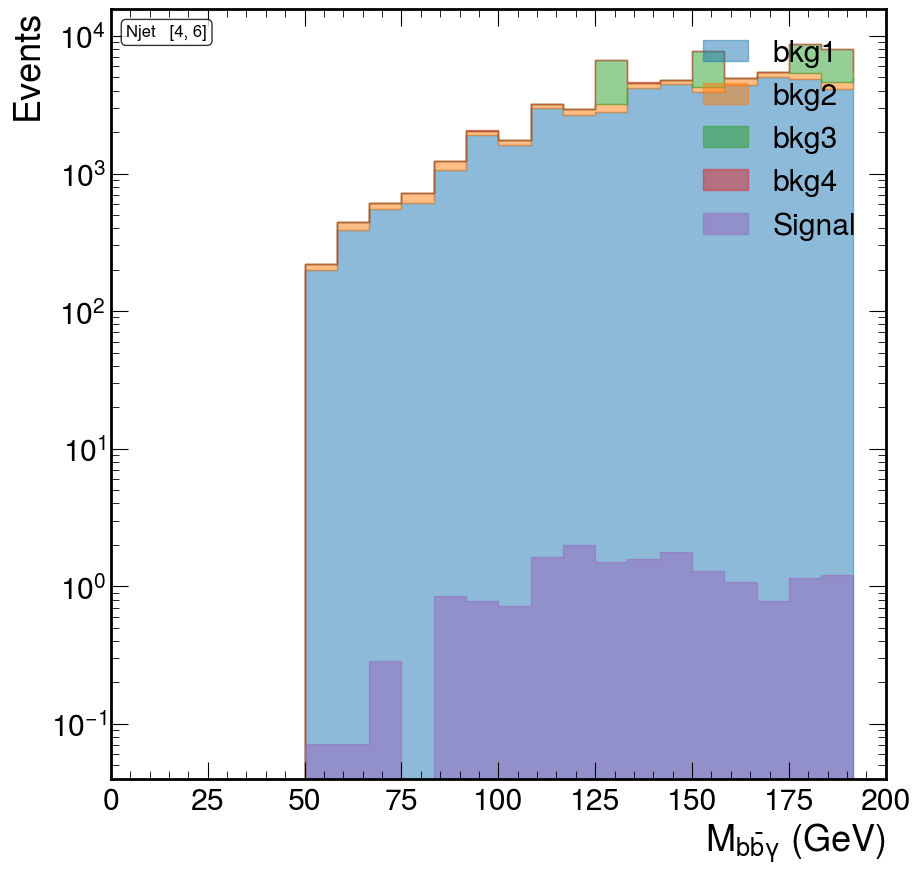

In [62]:
def plot_mass_bb_with_njet_cut(signal_mass, signal_njet,
                                              bkg1_mass, bkg1_njet,
                                              bkg2_mass, bkg2_njet,
                                              bkg3_mass, bkg3_njet,
                                              bkg4_mass, bkg4_njet,
                                              lumi_factors,
                                              njet_min=2, njet_max=3):

    print(f"\n绘制BB质量分布 (Njet切割: {njet_min}≤Njet≤{njet_max})...")
    
    signal_mask = (signal_njet >= njet_min) & (signal_njet <= njet_max)
    bkg1_mask = (bkg1_njet >= njet_min) & (bkg1_njet <= njet_max)
    bkg2_mask = (bkg2_njet >= njet_min) & (bkg2_njet <= njet_max)
    bkg3_mask = (bkg3_njet >= njet_min) & (bkg3_njet <= njet_max)
    bkg4_mask = (bkg4_njet >= njet_min) & (bkg4_njet <= njet_max)
    
    signal_mass_filtered = signal_mass[signal_mask]
    bkg1_mass_filtered = bkg1_mass[bkg1_mask]
    bkg2_mass_filtered = bkg2_mass[bkg2_mask]
    bkg3_mass_filtered = bkg3_mass[bkg3_mask]
    bkg4_mass_filtered = bkg4_mass[bkg4_mask]
    
    mass_bins = np.linspace(0, 200, 25)
    
    signal_mass_array = np.array(signal_mass_filtered)
    bkg1_mass_array = np.array(bkg1_mass_filtered)
    bkg2_mass_array = np.array(bkg2_mass_filtered)
    bkg3_mass_array = np.array(bkg3_mass_filtered)
    bkg4_mass_array = np.array(bkg4_mass_filtered)
    # calculate new factors
    
    lumi_factors = [lumi[0]*(signal_mask.sum()/len(signal_njet)),
                   lumi[1]*(bkg1_mask.sum()/len(bkg1_njet)),
                   lumi[2]*(bkg2_mask.sum()/len(bkg2_njet)),
                   lumi[3]*(bkg3_mask.sum()/len(bkg3_njet)),
                   lumi[4]*(bkg4_mask.sum()/len(bkg4_njet))]
    print(
        f"signal: {signal_mask.sum()}, {len(signal_njet)}\n",
        f"bkg1: {bkg1_mask.sum()}, {len(bkg1_njet)}\n",
        f"bkg2: {bkg2_mask.sum()}, {len(bkg2_njet)}\n",
        f"bkg3: {bkg3_mask.sum()}, {len(bkg3_njet)}\n",
        f"bkg4: {bkg4_mask.sum()}, {len(bkg4_njet)}\n"
    )
    signal_mass_mean, signal_mass_std, signal_mass_bin_c = ht.calculate_hist_stats(
        signal_mass_array, int(lumi_factors[0])+1, mass_bins)
    bkg1_mass_mean, bkg1_mass_std, bkg1_mass_bin_c = ht.calculate_hist_stats(
        bkg1_mass_array, int(lumi_factors[1])+1, mass_bins)
    bkg2_mass_mean, bkg2_mass_std, bkg2_mass_bin_c = ht.calculate_hist_stats(
        bkg2_mass_array, int(lumi_factors[2])+1, mass_bins)
    bkg3_mass_mean, bkg3_mass_std, bkg3_mass_bin_c = ht.calculate_hist_stats(
        bkg3_mass_array, int(lumi_factors[3])+1, mass_bins)
    bkg4_mass_mean, bkg4_mass_std, bkg4_mass_bin_c = ht.calculate_hist_stats(
        bkg4_mass_array, int(lumi_factors[4])+1, mass_bins)
    # significant = np.sqrt(signal_mask.sum() / (bkg1_mask.sum() + bkg2_mask.sum() + bkg3_mask.sum() + bkg4_mask.sum()))
    # print("significant", significant)    # 计算 signal 在 50–175 GeV 范围内的面积
    bin_width = mass_bins[1] - mass_bins[0]
    signal_mask_bins = (signal_mass_bin_c >= 50) & (signal_mass_bin_c <= 175)
    signal_area = signal_mass_mean[signal_mask_bins].sum() * bin_width
    # 计算各个背景在此区间的面积
    bkg1_mask_bins = (bkg1_mass_bin_c >= 50) & (bkg1_mass_bin_c <= 175)
    bkg2_mask_bins = (bkg2_mass_bin_c >= 50) & (bkg2_mass_bin_c <= 175)
    bkg3_mask_bins = (bkg3_mass_bin_c >= 50) & (bkg3_mass_bin_c <= 175)
    bkg4_mask_bins = (bkg4_mass_bin_c >= 50) & (bkg4_mass_bin_c <= 175)

    bkg1_area = bkg1_mass_mean[bkg1_mask_bins].sum() * bin_width
    bkg2_area = bkg2_mass_mean[bkg2_mask_bins].sum() * bin_width
    bkg3_area = bkg3_mass_mean[bkg3_mask_bins].sum() * bin_width
    bkg4_area = bkg4_mass_mean[bkg4_mask_bins].sum() * bin_width

    total_bkg_area = bkg1_area + bkg2_area + bkg3_area + bkg4_area

    print(f"Signal area in [50,175] GeV: {signal_area:.1f}")
    print(f"Background areas in [50,175] GeV: bkg1={bkg1_area:.1f}, bkg2={bkg2_area:.1f}, "
        f"bkg3={bkg3_area:.1f}, bkg4={bkg4_area:.1f}, total={total_bkg_area:.1f}")
    print("significant:", signal_area / np.sqrt(total_bkg_area))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    plt.figure(figsize=(10, 10))
    # plt.style.use(hep.style.CMS)  # 如果有hep模块可以取消注释
    
    plot_stacked_fill(
        bins=mass_bins,
        datasets=[bkg1_mass_mean, bkg2_mass_mean, bkg3_mass_mean, bkg4_mass_mean],
        labels=['bkg1', 'bkg2', 'bkg3', 'bkg4'],
        colors=colors[:4],
        signal_data=signal_mass_mean,
        signal_label='Signal'
    )
    
    plt.xlabel(r"$M_{b\bar{b}\gamma}$ (GeV)")
    plt.ylabel("Events")
    plt.xlim(0, 200)
    plt.yscale('log')
    plt.legend(loc='upper right')
    
    plt.text(0.02, 0.98, f'Njet ∈ [{njet_min}, {njet_max}]', 
             transform=plt.gca().transAxes, fontsize=12, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    return plt.gcf()

def plot_mbba_with_njet_cutdo():
    """绘制BBA质量分布，限制喷注数范围为2到5"""
    
    signal_mass = np.array(signal['BBA_mass'])
    signal_njet = np.array(signal['Njet'])
    
    bkg1_mass = np.array(bkg1['BBA_mass'])
    bkg1_njet = np.array(bkg1['Njet'])
    
    bkg2_mass = np.array(bkg2['BBA_mass'])
    bkg2_njet = np.array(bkg2['Njet'])
    
    bkg3_mass = np.array(bkg3['BBA_mass'])
    bkg3_njet = np.array(bkg3['Njet'])
    
    bkg4_mass = np.array(bkg4['BBA_mass'])
    bkg4_njet = np.array(bkg4['Njet'])
    fig2 = plot_mass_bb_with_njet_cut(signal_mass, signal_njet,
                                bkg1_mass, bkg1_njet,
                                bkg2_mass, bkg2_njet,
                                bkg3_mass, bkg3_njet,
                                bkg4_mass, bkg4_njet,
                                lumi,
                                njet_min=4, njet_max=6)
    fig2.savefig("figures/BBA_mass_with_njet_cut_4_6.png", dpi=300)

plot_mbba_with_njet_cutdo()
